<table style="float: left; width: 50%;">
    <thead>
        <tr>
            <th style="background-color: #ADD8E6; color: black; text-align: left; padding: 8px;">NIM</th>
            <th style="background-color: #ADD8E6; color: black; text-align: left; padding: 8px;">Nama</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left; padding: 8px;">12S19036</td>
            <td style="text-align: left; padding: 8px;">Lucas Hutabarat</td>
        </tr>
        <tr>
            <td style="text-align: left; padding: 8px;">12S21004</td>
            <td style="text-align: left; padding: 8px;">Estomihi Pangaribuan</td>
        </tr>
        <tr>
            <td style="text-align: left; padding: 8px;">12S21014</td>
            <td style="text-align: left; padding: 8px;">Fritz Kevin Manurung</td>
        </tr>
    </tbody>
</table>

### Import Library

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

warnings.filterwarnings("ignore")

In [2]:

# ------------------------------------------
# 1. Data Preprocessing
# ------------------------------------------

# Load dataset
data = pd.read_csv("data/Tempat-Wisata-Toba-Preprocessing.csv")
data = data.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "address"])

# Check missing values
print("Persentase Missing Value Rating: ", data["Rating"].isnull().sum()/len(data)*100)
print("Persentase Missing Value Reviews: ", data["Reviews"].isnull().sum()/len(data)*100)

# Fill missing values
data["Rating"] = data["Rating"].fillna(data["Rating"].mean())
data["Reviews"] = data["Reviews"].fillna("")

# Normalisasi Rating 1-5 menjadi 0-1
scaler = MinMaxScaler()
data["Rating"] = scaler.fit_transform(data[["Rating"]])

# Split data: train-validation-test (70:15:15)
train, test = train_test_split(data, test_size=0.3, random_state=42)
validation, test = train_test_split(test, test_size=0.5, random_state=42)

# Pivot tabel untuk user-item matrix
user_item_matrix = train.pivot_table(index='ReviewerId', columns='PlaceID', values='Rating', fill_value=0)

Persentase Missing Value Rating:  0.0023134224772127887
Persentase Missing Value Reviews:  48.72067737010133


In [3]:
# ------------------------------------------
# 2. Collaborative Filtering with SVD
# ------------------------------------------

# Load data ke dalam Dataset Surprise
reader = Reader(rating_scale=(0, 1))
data_surprise = Dataset.load_from_df(train[['ReviewerId', 'PlaceID', 'Rating']], reader)
data_surprise_test = Dataset.load_from_df(test[['ReviewerId', 'PlaceID', 'Rating']], reader)


# Hyperparameter tuning menggunakan GridSearchCV
param_grid = {'n_factors': [50, 100], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data_surprise)

# Ambil hasil dari GridSearchCV
best_rmse = grid_search.best_score['rmse']
best_params = grid_search.best_params['rmse']

# Tampilkan parameter terbaik dan RMSE terbaik
print(f"Best RMSE: {best_rmse}")
print(f"Best parameters from GridSearchCV: {best_params}")



Best RMSE: 0.22862678587203766
Best parameters from GridSearchCV: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1}


In [4]:
# ------------------------------------------
# 3. Train the model with best parameters
# ------------------------------------------

# Dapatkan parameter terbaik
model = SVD(n_factors=best_params['n_factors'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
model.fit(data_surprise.build_full_trainset())

In [5]:
# ------------------------------------------
# 4. Content-Based Filtering
# ------------------------------------------

# Menggabungkan Reviews berdasarkan PlaceID
place_reviews = train.groupby(['PlaceID', 'Nama_tempat_wisata'])['Reviews'].apply(lambda x: ' '.join(x)).reset_index()

# TF-IDF dan cosine similarity
stopwords = StopWordRemoverFactory().get_stop_words()
tfidf = TfidfVectorizer(stop_words=stopwords)
tfidf_matrix = tfidf.fit_transform(place_reviews['Reviews'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Mapping PlaceID ke index
place_indices = pd.Series(place_reviews.index, index=place_reviews['PlaceID'])

# Content-based recommendation function
def content_based_recommend(place_id, top_n=5):
    if place_id not in place_indices:
        print("PlaceID tidak ditemukan!")
        return
    idx = place_indices[place_id]
    sim_scores = sorted(list(enumerate(cosine_sim[idx])), key=lambda x: x[1], reverse=True)[1:top_n+1]
    place_indices_sim = [i[0] for i in sim_scores]
    return place_reviews.iloc[place_indices_sim][['PlaceID', 'Nama_tempat_wisata']].set_index('PlaceID')

In [6]:
# ------------------------------------------
# 5. Hybrid Recommendation
# ------------------------------------------

def hybrid_recommend(user_id, top_n=5, weight_svd=0.5, weight_cb=0.5):
    place_ids = train['PlaceID'].unique()
    hybrid_scores = []

    for place_id in place_ids:
        pred_svd = model.predict(user_id, place_id).est
        idx = place_indices[place_id]
        sim_scores = cosine_sim[idx].mean()
        hybrid_score = weight_svd * pred_svd + weight_cb * sim_scores
        hybrid_scores.append((place_id, hybrid_score))

    top_places = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return place_reviews[place_reviews['PlaceID'].isin([x[0] for x in top_places])][['PlaceID', 'Nama_tempat_wisata']]

In [7]:
# ------------------------------------------
# 6. Evaluation Metrics
# ------------------------------------------

def precision_recall_at_k(predictions, k=5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = [], []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(reverse=True)
        top_k = user_ratings[:k]
        n_rel = sum((true_r >= 0.5) for _, true_r in user_ratings)
        n_rec_k = sum((true_r >= 0.5) for _, true_r in top_k)
        precision = n_rec_k / k
        recall = n_rec_k / n_rel if n_rel else 0
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

def average_precision_at_k(predictions, k=5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    average_precisions = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(reverse=True)
        top_k = user_ratings[:k]

        n_rel = sum((true_r >= 0.5) for (_, true_r) in user_ratings)
        n_rec_k = sum((true_r >= 0.5) for (_, true_r) in top_k)

        ap = 0.0
        relevant_items = 0
        for i, (est, true_r) in enumerate(top_k, start=1):
            if true_r >= 0.5:
                relevant_items += 1
                ap += relevant_items / i
        
        if relevant_items > 0:
            ap /= relevant_items
        average_precisions.append(ap)

    mean_ap = sum(average_precisions) / len(average_precisions) if average_precisions else 0
    return mean_ap

In [8]:
# ------------------------------------------
# 7. Run Evaluations and Examples
# ------------------------------------------

# Test predictions
testset = data_surprise_test.build_full_trainset().build_testset()
predictions = model.test(testset)

# Precision & Recall
precision_5, recall_5 = precision_recall_at_k(predictions, k=5)
map_5 = average_precision_at_k(predictions, k=5)

precision_10, recall_10 = precision_recall_at_k(predictions, k=10)
map_10 = average_precision_at_k(predictions, k=10)

# Print evaluation results
print(f"Precision@5: {precision_5:.4f}")
print(f"Recall@5: {recall_5:.4f}")
print(f"MAP@5: {map_5:.4f}")

print(f"Precision@10: {precision_10:.4f}")
print(f"Recall@10: {recall_10:.4f}")
print(f"MAP@10: {map_10:.4f}")

Precision@5: 0.2408
Recall@5: 0.9596
MAP@5: 0.9559
Precision@10: 0.1205
Recall@10: 0.9598
MAP@10: 0.9559


RMSE: 0.2292
MAE:  0.1701


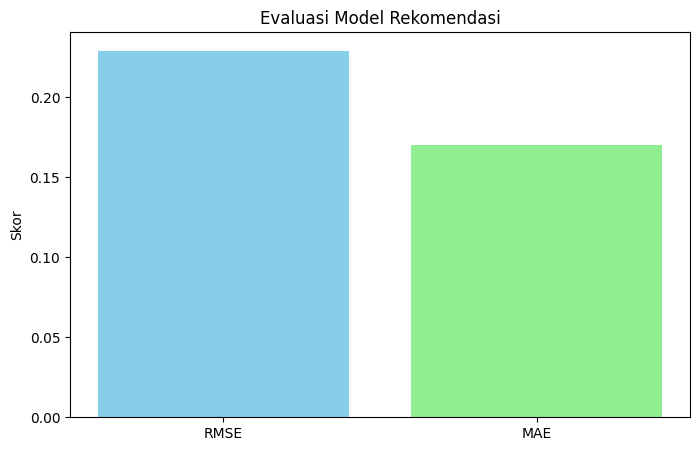

In [9]:
# Data evaluasi
metrics = ['RMSE', 'MAE']
values = [accuracy.rmse(predictions), accuracy.mae(predictions)]
# Visualisasi
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'orange', 'red', 'purple'])
plt.title('Evaluasi Model Rekomendasi')
plt.ylabel('Skor')
plt.show()

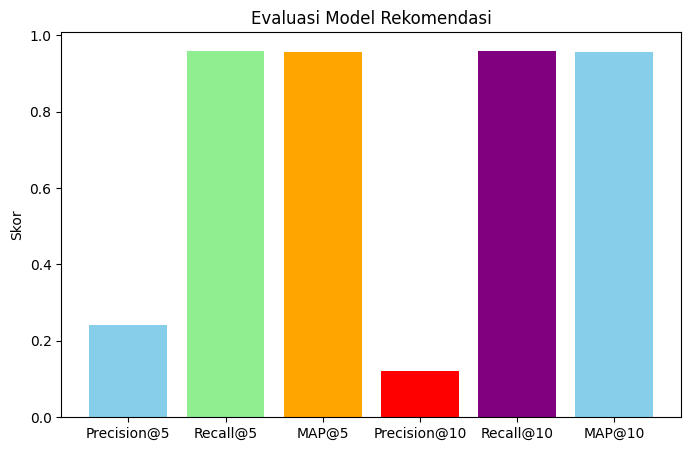

In [10]:
# tampilkan chart precision@5, recall@5, map@5
metrics = ['Precision@5', 'Recall@5', 'MAP@5', 'Precision@10', 'Recall@10', 'MAP@10']
values = [precision_5, recall_5, map_5, precision_10, recall_10, map_10]

# Visualisasi
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'orange', 'red', 'purple'])
plt.title('Evaluasi Model Rekomendasi')
plt.ylabel('Skor')
plt.show()



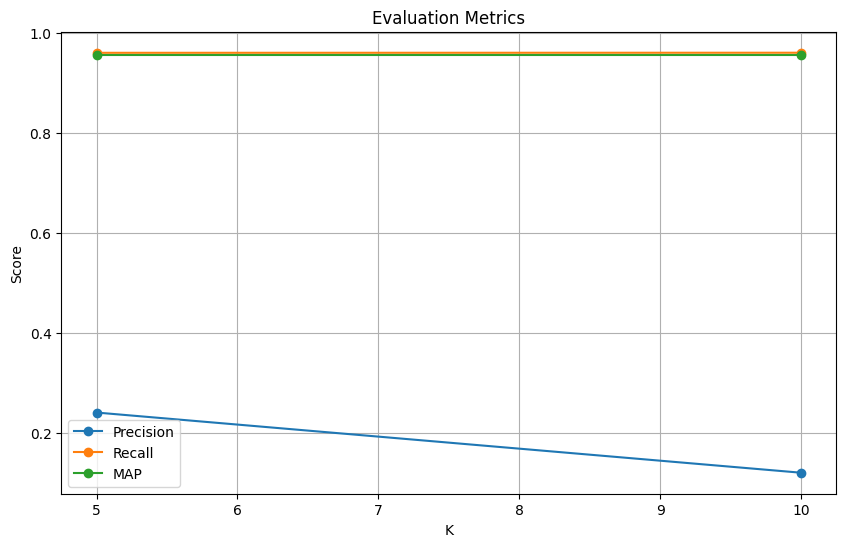

In [11]:
# grafik evaluasi
plt.figure(figsize=(10, 6))
plt.plot([5, 10], [precision_5, precision_10], marker='o', label='Precision')
plt.plot([5, 10], [recall_5, recall_10], marker='o', label='Recall')
plt.plot([5, 10], [map_5, map_10], marker='o', label='MAP')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid()
plt.show()

In [12]:
#rekomenadasi pariwisata untuk user id 1.000010e+20 dengan metode hybrid
print("Top 5 Rekomendasi Tempat Wisata untuk User ID 1.000010e+20:")
print(hybrid_recommend(1.000010e+20, top_n=5))


Top 5 Rekomendasi Tempat Wisata untuk User ID 1.000010e+20:
     PlaceID                Nama_tempat_wisata
51        52               Puncak Huta Ginjang
90        91             Bukit Holbung Samosir
91        92                  Geosite Sipinsur
99       100  Pantai Bebas Parapat, Danau Toba
100      101                Danau Toba Parapat


In [13]:
#rekomenadasi pariwisata untuk user id 1.000010e+20 dengan metode hybrid
print("Top 10 Rekomendasi Tempat Wisata untuk User ID 1.000010e+20:")
print(hybrid_recommend(1.000010e+20, top_n=10))

Top 10 Rekomendasi Tempat Wisata untuk User ID 1.000010e+20:
     PlaceID                Nama_tempat_wisata
19        20               Kaldera Sunset Hill
51        52               Puncak Huta Ginjang
59        60                     Bukit Sipolha
65        66                       The Kaldera
87        88                         Bukit Doa
90        91             Bukit Holbung Samosir
91        92                  Geosite Sipinsur
96        97                      Bukit Senyum
99       100  Pantai Bebas Parapat, Danau Toba
100      101                Danau Toba Parapat


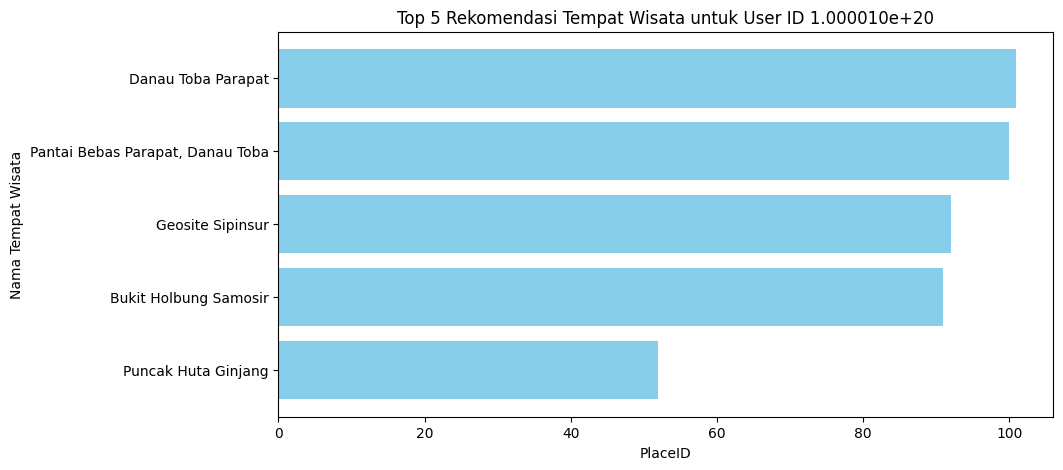

In [14]:
# buat dalam bentuk chart untuk top 5 rekomendasi tempat wisata untuk user id 1.000010e+20
top_5 = hybrid_recommend(1.000010e+20, top_n=5)
plt.figure(figsize=(10, 5))
plt.barh(top_5['Nama_tempat_wisata'], top_5['PlaceID'], color='skyblue')
plt.xlabel('PlaceID')
plt.ylabel('Nama Tempat Wisata')
plt.title('Top 5 Rekomendasi Tempat Wisata untuk User ID 1.000010e+20')
plt.show()


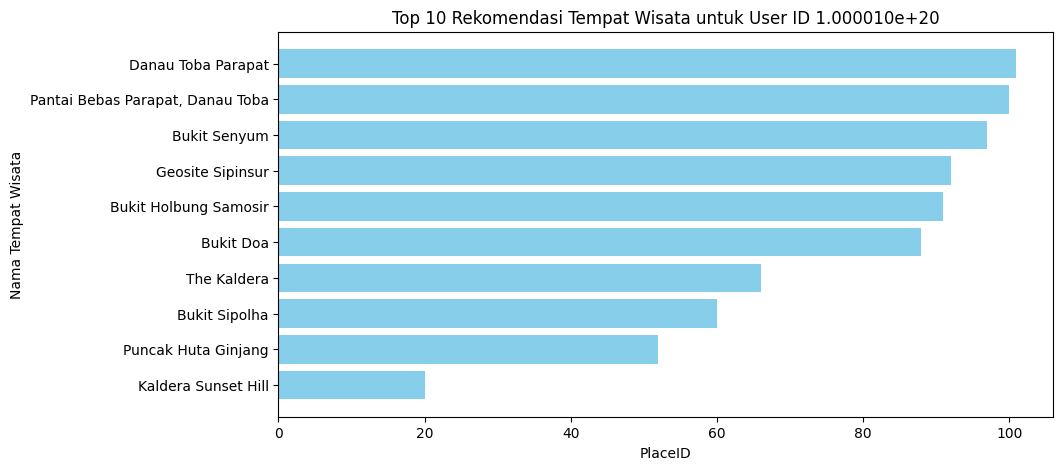

In [15]:
# buat dalam bentuk chart untuk top 10 rekomendasi tempat wisata untuk user id 1.000010e+20
top_10 = hybrid_recommend(1.000010e+20, top_n=10)
plt.figure(figsize=(10, 5))
plt.barh(top_10['Nama_tempat_wisata'], top_10['PlaceID'], color='skyblue')
plt.xlabel('PlaceID')
plt.ylabel('Nama Tempat Wisata')
plt.title('Top 10 Rekomendasi Tempat Wisata untuk User ID 1.000010e+20')
plt.show()